<a href="https://colab.research.google.com/github/Bhadrinathanvt/Covid-19-Lung-Image-Processing/blob/main/img_mask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from google.colab import files
uploaded = files.upload()

Saving Normal-10021.png to Normal-10021.png


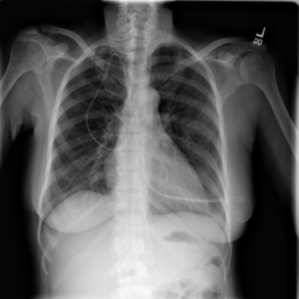

In [7]:
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
# Load an image from file
image = cv2.imread('Normal-10021.png')

cv2_imshow(image)

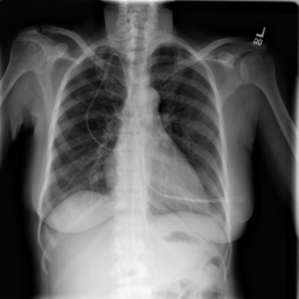

In [8]:
img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

cv2_imshow(img)

In [9]:
len(img.shape)

2

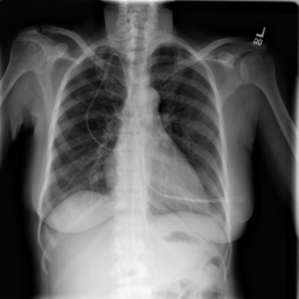

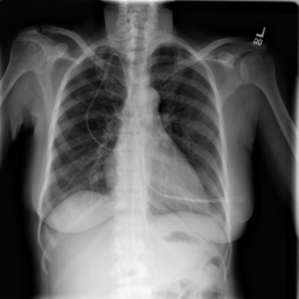

In [10]:
non_zero_coords = np.argwhere(img > 0)  # Get coordinates of all non-zero pixels
top_left = non_zero_coords.min(axis=0)  # Top-left corner of bounding box
bottom_right = non_zero_coords.max(axis=0)  # Bottom-right corner of bounding box

cropped_img = img[top_left[0]:bottom_right[0]+1, top_left[1]:bottom_right[1]+1]

resized_img = cv2.resize(cropped_img, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_LINEAR)

from google.colab.patches import cv2_imshow
cv2_imshow(img)
cv2_imshow(resized_img)

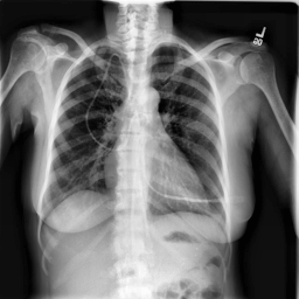

In [11]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4, 4))

# Step 3: Apply CLAHE to the image
clahe_img = clahe.apply(resized_img)

# Step 4: Display the result
cv2_imshow(clahe_img)

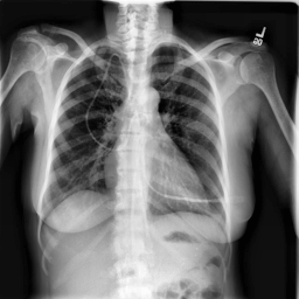

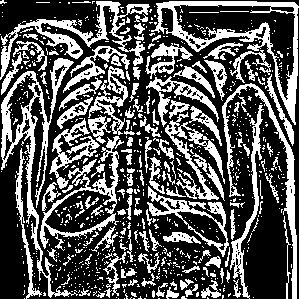

In [12]:
# Apply adaptive thresholding
adaptive_thresh = cv2.adaptiveThreshold(clahe_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                        cv2.THRESH_BINARY, 11, 2)

# Create the negative of the adaptive thresholded image
adaptive_thresh_negative = 255 - adaptive_thresh

# Display the original and the negative of the adaptive thresholded image
cv2_imshow(clahe_img)
cv2_imshow(adaptive_thresh_negative)

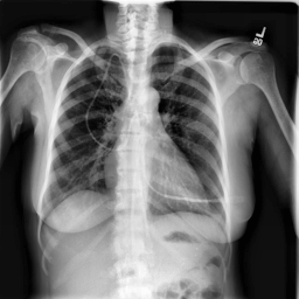

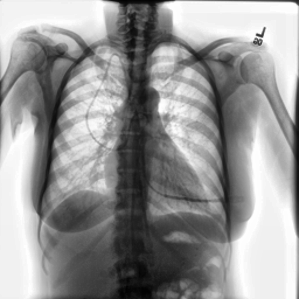

In [13]:
# Subtract the original image from the adaptive thresholded image
sub_img = adaptive_thresh - clahe_img

# Display the original and the subtracted image
cv2_imshow(clahe_img)
cv2_imshow(sub_img)

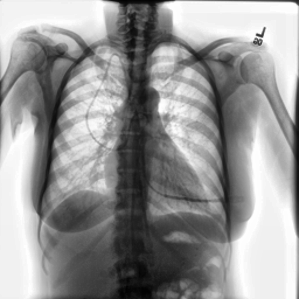

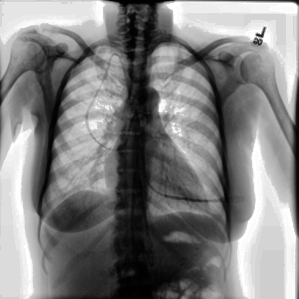

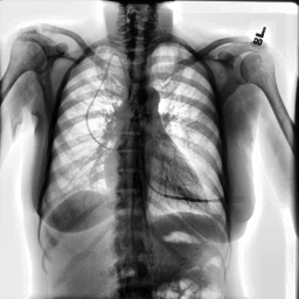

In [14]:
# Apply Histogram Equalization
img_equalized = cv2.equalizeHist(sub_img)
img_eqs = clahe.apply(sub_img)

# Display the original and equalized images
cv2_imshow(sub_img)
cv2_imshow(img_equalized)
cv2_imshow(img_eqs)

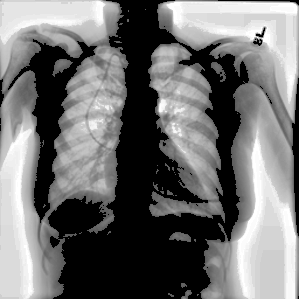

In [15]:
# Define intensity range for lung area (this is just an example, may need adjustment)
lower_bound = 90
upper_bound = 255

# Create a mask for the lung region
lung_mask = cv2.inRange(img_equalized, lower_bound, upper_bound)

# Apply the mask to extract lung regions
lung_region = cv2.bitwise_and(img_equalized, img_equalized, mask=lung_mask)

# Display the result
cv2_imshow(lung_region)

In [16]:
proc_img = lung_region

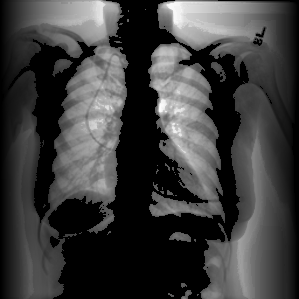

In [28]:
#  Get the image dimensions (height and width)
height, width = proc_img.shape

# Create a Gaussian mask
# Generate X and Y coordinates
x = np.linspace(-1, 1, width)
y = np.linspace(-1, 1, height)
x, y = np.meshgrid(x, y)

# Calculate the distance from the center
distance = np.sqrt(x**2)

# Create a Gaussian mask
# Gaussian function: exp(-(distance^2)/(2*sigma^2))
sigma = 10 # Adjust the value of sigma to control the spread of the vignette
gaussian_mask = np.exp(-(distance**2) / (2 * sigma**2))

# Normalize the mask (ensure max value is 1)
gaussian_mask = cv2.normalize(gaussian_mask, None, 0, 1, cv2.NORM_MINMAX)

# Apply the Gaussian mask to the grayscale image
output_img = proc_img * (gaussian_mask)  # Scale the mask back to 255

# Convert the result back to uint8
output_img = np.clip(output_img, 0, 255).astype(np.uint8)

# Display the result
cv2_imshow(output_img)

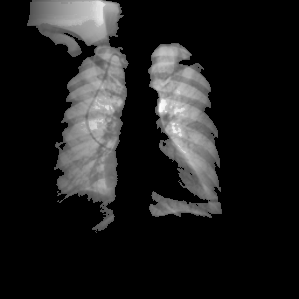

In [29]:
# Threshold to create a binary image (white pixels become 1, others become 0)
_, binary = cv2.threshold(output_img, 80, 255, cv2.THRESH_BINARY)

# Find connected components (regions of white pixels)
num_labels, labels = cv2.connectedComponents(binary)

# Find properties of each component (like area)
stats = cv2.connectedComponentsWithStats(binary)[2]

# Sort the components by area, and select the two largest
areas = stats[1:, cv2.CC_STAT_AREA]  # Skip the background (label 0)
sorted_indices = np.argsort(areas)[::-1]  # Sort indices by area in descending order

# Create a mask for the two largest regions
mask = np.zeros_like(binary)
for i in sorted_indices[:2]:  # Loop through the two largest components
    mask[labels == i + 1] = 255  # Set pixels belonging to these regions to 255 (white)

# Apply the mask to the original image to extract the two largest regions
output_imag = cv2.bitwise_and(output_img, output_img, mask=mask)

# Show the result
cv2_imshow(output_imag)

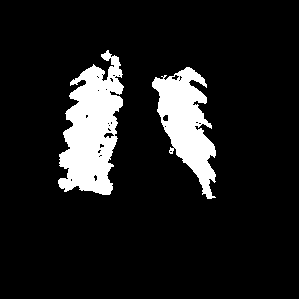

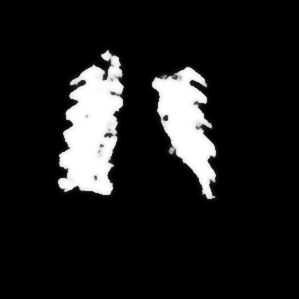

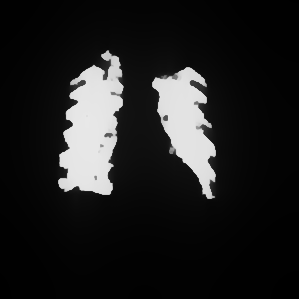

In [ ]:
smooth_image = cv2.GaussianBlur(output_imag, (3, 3), 0)
bilateral_image = cv2.bilateralFilter(smooth_image, 9, 75, 75)
edgePreserving_image = cv2.edgePreservingFilter(bilateral_image, sigma_s=64, sigma_r=0.25)


# Show the original and smoothed image
cv2_imshow(output_imag)
cv2_imshow(bilateral_image)
cv2_imshow(edgePreserving_image)


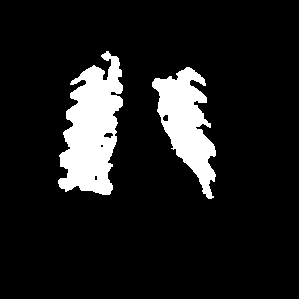

In [ ]:
_, FinalMask = cv2.threshold(edgePreserving_image, 150, 255, cv2.THRESH_BINARY)
# Create an output image where the mask region is 255 and non-mask region is 0
final_img = np.zeros_like(edgePreserving_image)  # Create an image of the same shape as the original, filled with 0 (black)

# Apply the mask, setting the image inside the mask to 255
final_img[FinalMask == 255] = 255  # Set the masked region to white (255)

cv2_imshow(final_img)